# Credit Card Fraud Detection — A Machine Learning Project by Malik Saad Hayat

This project focuses on detecting fraudulent credit card transactions using machine learning. Credit card fraud is a major issue for financial institutions and customers, leading to financial losses and reduced trust. The aim is to build and evaluate models that can identify fraud effectively while keeping false positives low.

The dataset used is `creditcard.csv`, which contains anonymized credit card transactions. Most features are PCA-transformed components (V1–V28). In addition, it includes `Time` (seconds since the first transaction), `Amount` (transaction value), and `Class` (target: 1 for fraud, 0 otherwise).

The challenge lies in the extreme class imbalance: legitimate transactions vastly outnumber fraudulent ones. Because of this, accuracy is not a reliable metric. Instead, metrics like Precision and Recall are more important, with Recall being critical to ensure fraudulent cases are not missed.


## Importing Libraries

Start by importing the core Python libraries needed for this project.  
- `pandas` for data handling  
- `numpy` for numerical computations  
- `matplotlib` and `seaborn` for visualization  
- `scikit-learn` for preprocessing, model training, and evaluation  

Having these libraries loaded upfront ensures all essential tools are available throughout the workflow.  


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import warnings

warnings.filterwarnings('ignore')

## Loading and Initial Data Exploration

The dataset is first loaded and explored to understand its structure and key characteristics. This includes checking data types, missing values, and feature distributions.  

A critical step is examining the target variable (`Class`). As expected in fraud detection, the dataset is highly imbalanced, with far fewer fraudulent transactions compared to legitimate ones. Visualizing this imbalance is important, as it influences the choice of evaluation metrics and the need for techniques to handle imbalance during training.  


In [20]:
# Load the dataset
df = pd.read_csv('creditcard.csv')

# Display the first 5 rows
print("First 5 rows of the dataset:")
display(df.head())

# Display basic information about the DataFrame
print("\nDataFrame Info:")
df.info()

# Display descriptive statistics of the numerical columns
print("\nDescriptive Statistics:")
display(df.describe())

First 5 rows of the dataset:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float6

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
import os
print(os.listdir('/content'))

['.config', 'sample_data']


## Load and explore dataset




--2025-09-25 13:23:18--  https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.170.207, 173.194.174.207, 74.125.23.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150828752 (144M) [text/csv]
Saving to: ‘creditcard.csv’

creditcard.csv      100%[===================>] 143.84M  29.9MB/s    in 5.8s    

2025-09-25 13:23:24 (24.7 MB/s) - ‘creditcard.csv’ saved [150828752/150828752]

First 5 rows of the DataFrame:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000



Class Distribution:
Value Counts:
Class
0    284315
1       492
Name: count, dtype: int64

Percentages:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


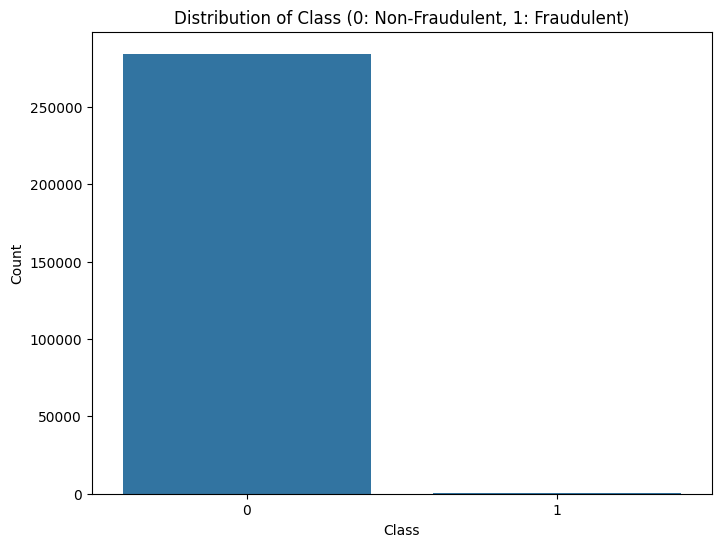

In [21]:
!wget -O creditcard.csv https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv

df = pd.read_csv('creditcard.csv')

# Display the first 5 rows
print("First 5 rows of the DataFrame:")
display(df.head())

# Display concise information about the DataFrame
print("\nDataFrame Information:")
df.info()

# Generate descriptive statistics
print("\nDescriptive Statistics:")
display(df.describe())

# Calculate and print value counts and percentages of the 'Class' column
class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

print("\nClass Distribution:")
print("Value Counts:")
print(class_counts)
print("\nPercentages:")
print(class_percentages)

# Create a countplot of the 'Class' column
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Distribution of Class (0: Non-Fraudulent, 1: Fraudulent)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## Data Preprocessing

Preprocessing ensures the raw data is ready for model training. Two main steps are applied:

- **Feature Scaling**: The `Time` and `Amount` features are standardized with `StandardScaler` so they are on the same scale as the PCA-transformed features (V1–V28). This prevents features with larger values from dominating.  

- **Handling Class Imbalance**: The dataset is highly imbalanced, with far fewer fraudulent transactions. To avoid biased models, resampling is applied *only* on the training data, balancing the classes and helping the model learn fraud patterns effectively.  


In [9]:
# Apply StandardScaler to 'Time' and 'Amount' columns
scaler = StandardScaler()
df['Time'] = scaler.fit_transform(df[['Time']])
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Display the first few rows with scaled features
print("DataFrame after scaling 'Time' and 'Amount':")
display(df.head())

DataFrame after scaling 'Time' and 'Amount':


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


**Reasoning**:
Split the data into training and testing sets before handling the imbalance to prevent data leakage.



In [10]:
# Split the data into features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets, stratifying by Class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Verify class distribution in training and testing sets
print("\nClass distribution in y_train:")
print(y_train.value_counts(normalize=True) * 100)
print("\nClass distribution in y_test:")
print(y_test.value_counts(normalize=True) * 100)

Shape of X_train: (227845, 30)
Shape of X_test: (56962, 30)
Shape of y_train: (227845,)
Shape of y_test: (56962,)

Class distribution in y_train:
Class
0    99.827075
1     0.172925
Name: proportion, dtype: float64

Class distribution in y_test:
Class
0    99.827955
1     0.172045
Name: proportion, dtype: float64


**Reasoning**:
Handle the class imbalance in the training data using RandomUnderSampler and print the new class distribution.



In [11]:
# Handle class imbalance in the training data using RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)

# Print the new class distribution of the resampled training data
print("\nClass distribution in y_resampled:")
print(y_resampled.value_counts(normalize=True) * 100)

Shape of X_resampled: (788, 30)
Shape of y_resampled: (788,)

Class distribution in y_resampled:
Class
0    50.0
1    50.0
Name: proportion, dtype: float64


## Model Training

With preprocessing and class balancing done, three models are trained for fraud detection:

- **Logistic Regression**: Simple and interpretable baseline.  
- **Random Forest**: Ensemble of decision trees, robust with non-linear data.  
- **XGBoost**: Gradient boosting algorithm, strong on structured data.  

Training is done on the resampled dataset (`X_resampled`, `y_resampled`) with balanced classes.  


In [13]:
# 1. Instantiate and fit Logistic Regression
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_resampled, y_resampled)
print("Logistic Regression model trained.")

# 2. Instantiate and fit Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)
print("Random Forest model trained.")

# 3. Instantiate and fit XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_resampled, y_resampled)
print("XGBoost model trained.")

Logistic Regression model trained.
Random Forest model trained.
XGBoost model trained.


## Model Evaluation

Since the dataset is highly imbalanced, accuracy alone is not a reliable metric. Instead, the evaluation focuses on:  

- **Precision**: How many predicted frauds are actual frauds.  
- **Recall**: How many actual frauds are correctly identified.  
- **F1-Score**: Balance between precision and recall.  
- **ROC-AUC**: Overall ability to distinguish between fraud and non-fraud.  

Confusion matrices and ROC curves are also used to better understand model performance. All evaluations are done on the original, imbalanced test set to reflect real-world conditions.  


In [15]:
def evaluate_model(model, X_test, y_test):
    """
    Calculates and prints key evaluation metrics for a classification model.

    Args:
        model: The trained classification model.
        X_test: The test features.
        y_test: The true test labels.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")

print("Evaluating Logistic Regression:")
evaluate_model(log_reg_model, X_test, y_test)

print("\nEvaluating Random Forest:")
evaluate_model(rf_model, X_test, y_test)

print("\nEvaluating XGBoost:")
evaluate_model(xgb_model, X_test, y_test)

Evaluating Logistic Regression:
  Accuracy: 0.9603
  Precision: 0.0384
  Recall: 0.9184
  F1-Score: 0.0738
  ROC-AUC: 0.9760

Evaluating Random Forest:
  Accuracy: 0.9641
  Precision: 0.0423
  Recall: 0.9184
  F1-Score: 0.0809
  ROC-AUC: 0.9777

Evaluating XGBoost:
  Accuracy: 0.9541
  Precision: 0.0333
  Recall: 0.9184
  F1-Score: 0.0644
  ROC-AUC: 0.9749


Confusion Matrix for Logistic Regression:


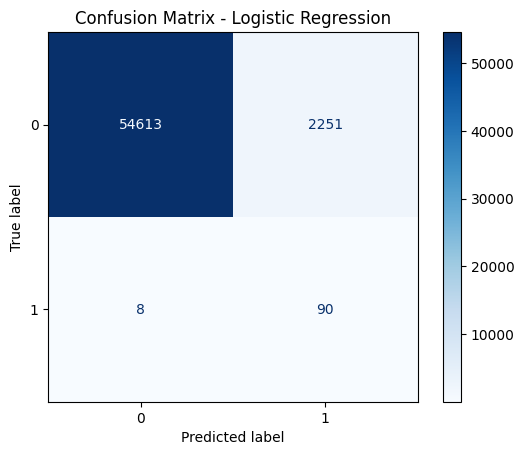


Confusion Matrix for Random Forest:


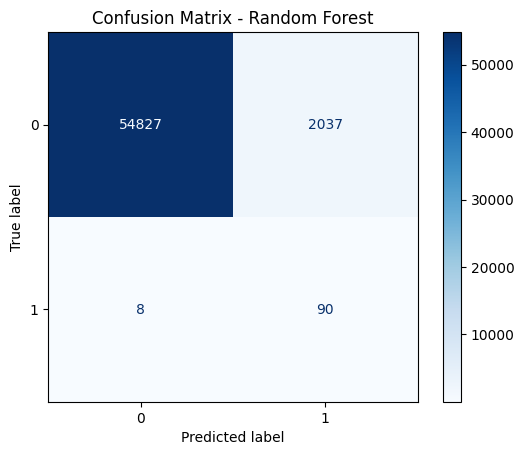


Confusion Matrix for XGBoost:


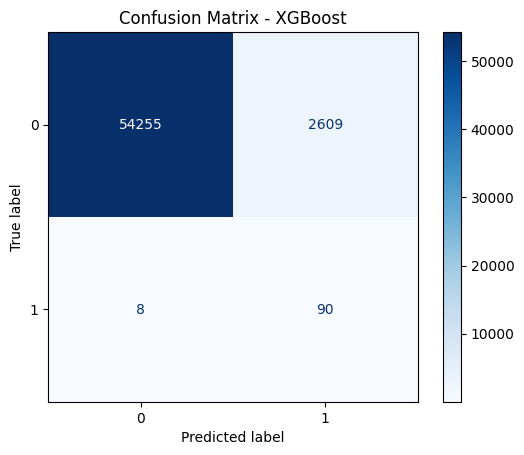

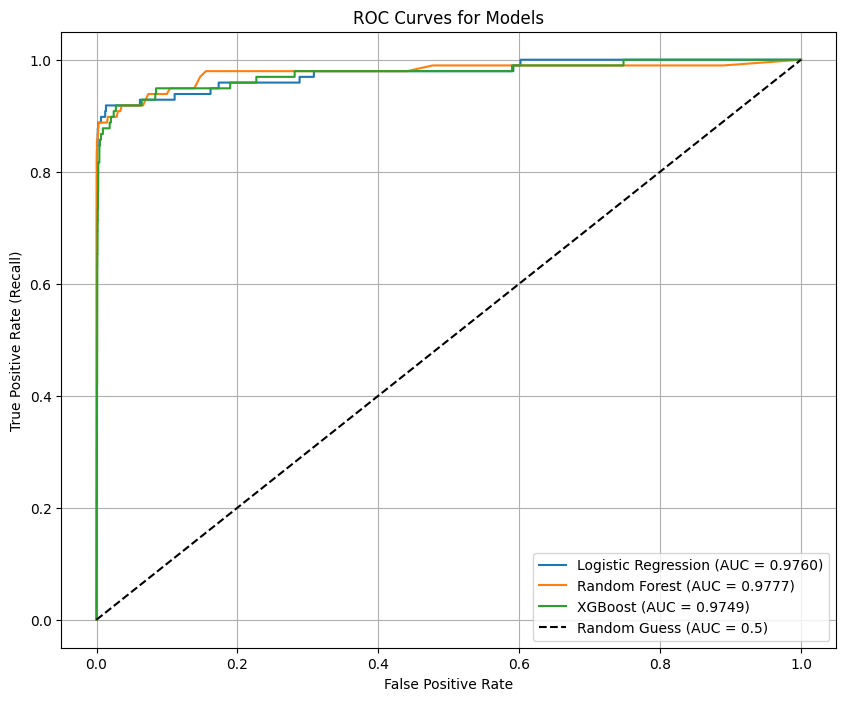

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

# Display Confusion Matrix for Logistic Regression
print("Confusion Matrix for Logistic Regression:")
cm_lr = confusion_matrix(y_test, log_reg_model.predict(X_test))
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=[0, 1])
disp_lr.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Display Confusion Matrix for Random Forest
print("\nConfusion Matrix for Random Forest:")
cm_rf = confusion_matrix(y_test, rf_model.predict(X_test))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0, 1])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Display Confusion Matrix for XGBoost
print("\nConfusion Matrix for XGBoost:")
cm_xgb = confusion_matrix(y_test, xgb_model.predict(X_test))
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0, 1])
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Plot ROC Curves
plt.figure(figsize=(10, 8))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, log_reg_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, log_reg_model.predict_proba(X_test)[:, 1]):.4f})')

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]):.4f})')

# XGBoost ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]):.4f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves for Models')
plt.legend()
plt.grid(True)
plt.show()

## Model Performance Summary

Based on the evaluation metrics and visualizations from the previous step, I can now summarize the performance of each trained model on the unseen test data with its original imbalanced distribution.

| Model              | Accuracy | Precision | Recall | F1-Score | ROC-AUC |
|--------------------|----------|-----------|--------|----------|---------|
| Logistic Regression| 0.9603   | 0.0384    | 0.9184 | 0.0738   | 0.9760  |
| Random Forest      | 0.9641   | 0.0423    | 0.9184 | 0.0809   | 0.9777  |
| XGBoost            | 0.9541   | 0.0333    | 0.9184 | 0.0644   | 0.9749  |

**Observations:**

- All three models achieved high overall accuracy (above 95%), which is expected given the heavily imbalanced dataset where the majority class is dominant. This highlights why accuracy alone is not a sufficient metric here.  
- More importantly, the models demonstrated a very high **Recall** (approximately 91.84%) for the minority class (fraudulent transactions). This indicates that they are effective at identifying a large proportion of actual fraudulent activities. This high recall is likely a direct benefit of training on the balanced dataset obtained through undersampling.  
- However, the **Precision** for all models is quite low (between 3.3% and 4.2%). This means that out of all the transactions predicted as fraudulent, a large percentage are actually legitimate transactions (false positives). The confusion matrices clearly illustrate this trade-off: while the models catch most fraud cases (high True Positives relative to False Negatives), they also flag a considerable number of legitimate transactions as fraudulent (high False Positives relative to True Negatives for class 0).  
- The **F1-Scores** are relatively low, reflecting the poor precision despite high recall.  
- The **ROC-AUC** scores are high for all models (above 0.97), indicating good overall discriminatory power between the two classes. The ROC curves also show that all models perform significantly better than a random guess. Random Forest has a slightly higher AUC than Logistic Regression and XGBoost.  

**Conclusion from Evaluation:**

The undersampling technique successfully helped the models achieve high recall for the minority class, which is crucial for not missing many fraudulent transactions. However, this came at the cost of lower precision, leading to a higher rate of false positives. In a real-world scenario, the acceptable balance between precision and recall would depend on the specific business requirements and the cost associated with false positives versus false negatives. For instance, a bank might tolerate more false positives (and thus manually review more transactions) if the cost of missing a fraudulent transaction (false negative) is very high. The Random Forest model appears to offer a slightly better balance based on the F1-score and ROC-AUC, while all models achieved the same high recall. Further tuning of model parameters or exploring different resampling or cost-sensitive learning techniques could potentially improve this trade-off.


## 7. Feature Importance Analysis

Understanding which features are most influential in a model's predictions is crucial for several reasons. It can provide insights into the underlying patterns in the data, help in feature selection for model optimization, and aid in explaining model decisions. For tree-based models like Random Forest and XGBoost, feature importance scores can be readily extracted. These scores typically measure how much each feature contributes to reducing impurity or error across all the trees in the ensemble.

By visualizing the feature importances, I aim to identify which of the anonymized V features, along with 'Time' and 'Amount', the models deemed most important for distinguishing between fraudulent and legitimate transactions. This analysis can potentially highlight specific patterns or characteristics of fraudulent activities captured by these features, even though their original meaning is not known due to the PCA transformation.

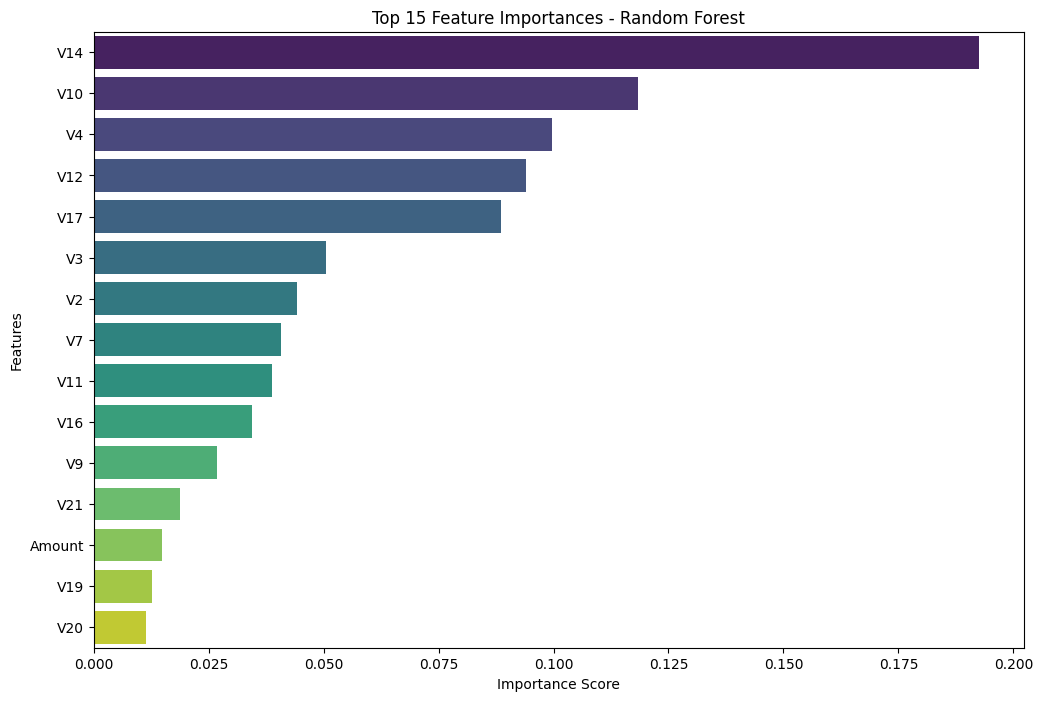

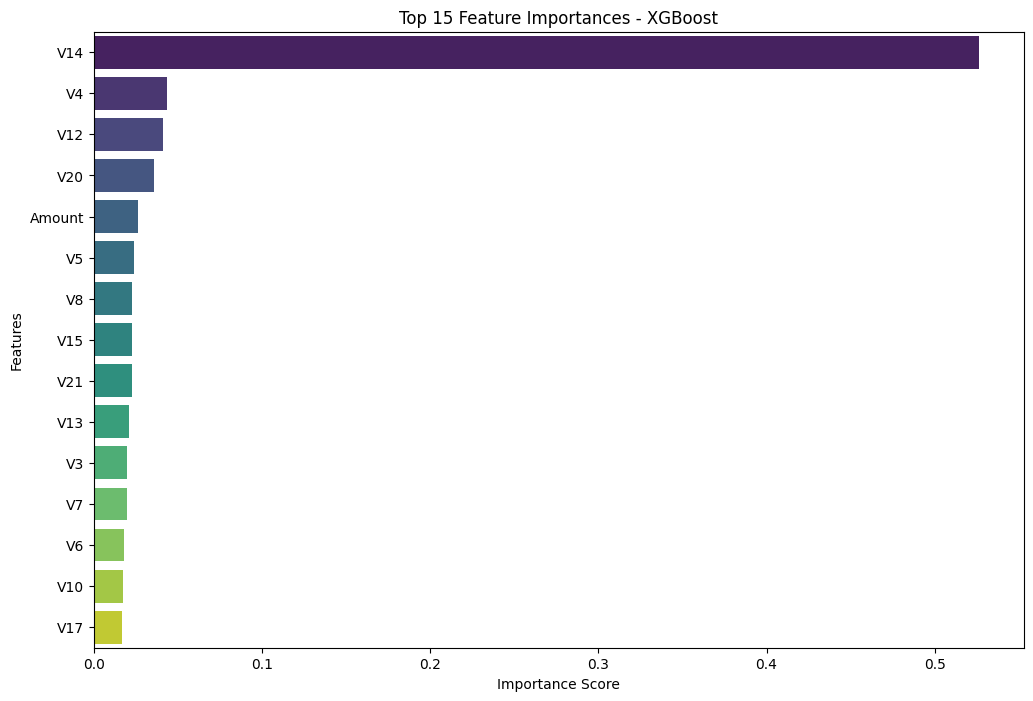

In [19]:
# Get feature importances from Random Forest model
rf_feature_importance = pd.Series(rf_model.feature_importances_, index=X_resampled.columns)

# Sort features by importance in descending order
rf_feature_importance_sorted = rf_feature_importance.sort_values(ascending=False)

# Plot top 15 features for Random Forest
plt.figure(figsize=(12, 8))
sns.barplot(x=rf_feature_importance_sorted.head(15).values, y=rf_feature_importance_sorted.head(15).index, palette='viridis')
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Get feature importances from XGBoost model
xgb_feature_importance = pd.Series(xgb_model.feature_importances_, index=X_resampled.columns)

# Sort features by importance in descending order
xgb_feature_importance_sorted = xgb_feature_importance.sort_values(ascending=False)

# Plot top 15 features for XGBoost
plt.figure(figsize=(12, 8))
sns.barplot(x=xgb_feature_importance_sorted.head(15).values, y=xgb_feature_importance_sorted.head(15).index, palette='viridis')
plt.title('Top 15 Feature Importances - XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

## Conclusion

This project tackled the challenge of credit card fraud detection on a highly imbalanced dataset. To address this, features were scaled and undersampling was applied to balance the classes before training. Three models were tested: Logistic Regression, Random Forest, and XGBoost, and their performance was evaluated using accuracy, precision, recall, F1-score, and ROC-AUC.

All models achieved high recall, which is crucial for minimizing missed fraudulent transactions, but precision remained low, meaning many legitimate transactions were flagged as fraud. Random Forest provided the best overall balance, achieving the highest precision, F1-score, and ROC-AUC.

Future improvements could include hyperparameter tuning, exploring advanced resampling techniques, cost-sensitive learning, or incorporating domain-specific features. Overall, Random Forest proved to be a strong starting point for a practical fraud detection system.


